# EEG Phase-Amplitude Coupling (PAC) Analysis

This code contains the implementation details for calculating **theta-gamma** and **theta-alpha phase-amplitude coupling (PAC)** metrics.




In [ ]:
!pip install -U gdown


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1RXWccgAtXi8mC6Bkmkl5v1lJ04-VqMMq


Retrieving folder contents
Processing file 1gTfKNyQp8iAmObHqmIn4kXU1NWCKQs3T p1_e1_preprocessed.fdt
Processing file 10B722c_tOZOophp7mfRq86NGmXJRxDWY p1_e1_preprocessed.set
Processing file 11kF24AvwyqOmryGe3DphpWlf1m4AgQjx p1_e2_preprocessed.fdt
Processing file 1JKQst6HOlEklmcpsL8yKF_q3tewic22p p1_e2_preprocessed.set
Processing file 1Y3dP_1OHsUPWtC_9B6r4mU5XzE4UFPE2 p2_e1_preprocessed.fdt
Processing file 1btmBvsL1ZherXdMd5xIlYEScodF7Ai6F p2_e1_preprocessed.set
Processing file 1BFcKnoJS7vBFY-4JGC60nHj78ttscCNQ p2_e2_preprocessed.fdt
Processing file 1t2bmjCMhlEE0AsMLsswxs7wAyz176jl7 p2_e2_preprocessed.set
Processing file 1cPOD2FlGDm975elfLSZTO9sHppQ1GNLu p3_e1_preprocessed.fdt
Processing file 11wtGFXdTav8h62C-aBhJAS_T9oT2mKac p3_e1_preprocessed.set
Processing file 1ue3YnwpiAMTZmXcz1r9y8zN05-J_Er3T p3_e2_preprocessed.fdt
Processing file 1YQtNBGzOUDMbBKSiFrLaDn9-8KVH1CNU p3_e2_preprocessed.set
Processing file 1-ARnsNe_7vqxQPoViTq7S3cPr5dUJC3c p4_e1_preprocessed.fdt
Processing file 16RgAU96

In [ ]:
!pip install mne pymatreader




## **Overview**
Phase-amplitude coupling quantifies how the phase of a lower frequency oscillation (theta: 4–8 Hz) modulates the amplitude of a higher frequency oscillation (gamma: 30–80 Hz; alpha: 8–12 Hz). These metrics are calculated using an **entropy-based Modulation Index (MI)**.


In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
import os


EEG signals are bandpass-filtered into three frequency bands:
- **Theta (θ):** 4–8 Hz (phase carrier)
- **Alpha (α):** 8–12 Hz (amplitude)
- **Gamma (γ):** 30–80 Hz (amplitude)


Given an EEG signal $ s(t) $:


### **Theta Phase Extraction (4–8 Hz)**

$$
s_{\theta}(t) = \text{BPF}_{4-8\text{Hz}}(s(t))
$$

$$
\phi_{\theta}(t) = \arg\left(\mathcal{H}[s_{\theta}(t)]\right)
$$

Where $ \mathcal{H} $ is the **Hilbert Transform**.



### **Gamma Band Amplitude Extraction (30–80 Hz)**

$$
s_{\gamma}(t) = \text{BPF}_{30-80\text{Hz}}(s(t))
$$

$$
A_{\gamma}(t) = \left|\mathcal{H}[s_{\gamma}(t)]\right|
$$



### **Alpha Band Amplitude Extraction (8–12 Hz)**

$$
s_{\alpha}(t) = \text{BPF}_{8-12\text{Hz}}(s(t))
$$

$$
A_{\alpha}(t) = \left|\mathcal{H}[s_{\alpha}(t)]\right|
$$




In [ ]:
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)



###  Phase / Amplitude Extraction
- **Phase:** Extracted via Hilbert transform from theta-filtered signals  
- **Amplitude:** Extracted via Hilbert transform from alpha/gamma signals  



## **2. Phase-Amplitude Coupling (PAC) Computation**

Let $ n_{\text{bins}} = 18 $ be the number of phase bins.



### **Phase Binning**

$$
\Phi_i = \left[ -\pi + \frac{2\pi(i-1)}{n_{\text{bins}}}, -\pi + \frac{2\pi i}{n_{\text{bins}}} \right), \quad i \in \{1,\ldots,n_{\text{bins}}\}
$$



### **Amplitude Averaging per Phase Bin**

$$
\langle A \rangle_i = \frac{1}{N_i} \sum_{t:\phi_{\theta}(t)\in\Phi_i} A_{\text{band}}(t)
$$

Where $ N_i $ is the number of time points such that $ \phi_{\theta}(t) \in \Phi_i $.



### **Probability Distribution**

$$
P_i = \frac{\langle A \rangle_i}{\sum_{j=1}^{n_{\text{bins}}} \langle A \rangle_j}
$$



### **Shannon Entropy**

$$
H = -\sum_{i=1}^{n_{\text{bins}}} P_i \ln P_i
$$



### **Modulation Index (MI)**

$$
\text{MI} = \frac{H_{\text{max}} - H}{\ln n_{\text{bins}}}, \quad \text{where } H_{\text{max}} = \ln n_{\text{bins}}
$$




In [ ]:
def compute_MI(phase_data, amp_data, n_bins=18):
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_means = np.zeros(n_bins)

    # Compute mean amplitude in each phase bin
    for i in range(n_bins):
        mask = (phase_data >= bins[i]) & (phase_data < bins[i + 1])
        bin_means[i] = np.mean(amp_data[mask]) if np.any(mask) else 0.0

    # Calculate normalized entropy
    P = bin_means / (np.sum(bin_means) + 1e-8)  # Avoid division by zero
    H = -np.sum(P * np.log(P + 1e-8))  # Avoid log(0)
    Hmax = np.log(n_bins)

    return (Hmax - H) / Hmax


In [ ]:
dataset_path = "/content/dataset/"
output_base = "/content/processed_results/"

In [ ]:
os.makedirs(os.path.join(output_base, "theta_alpha"), exist_ok=True)
os.makedirs(os.path.join(output_base, "theta_gamma"), exist_ok=True)

In [ ]:
os.makedirs(output_base, exist_ok=True)

In [ ]:
set_files = [f for f in os.listdir(dataset_path) if f.endswith('.set')]

In [ ]:
for set_file in set_files:
    print(f"\nProcessing {set_file}...")
    base_name = os.path.splitext(set_file)[0]

    # Load EEG data
    epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
    eeg_data = epochs.get_data()
    fs = int(epochs.info['sfreq'])

    # Initialize matrices
    n_epochs, n_channels, n_times = eeg_data.shape
    theta_gamma_matrix = np.zeros((n_channels, n_epochs))
    theta_alpha_matrix = np.zeros((n_channels, n_epochs))

    # Phase-amplitude coupling calculation
    for ch in range(n_channels):
        for ep in range(n_epochs):
            signal = eeg_data[ep, ch, :]

            # Theta phase
            theta_phase = np.angle(hilbert(bandpass_filter(signal, 4, 8, fs)))

            # Gamma coupling
            gamma_amp = np.abs(hilbert(bandpass_filter(signal, 30, 80, fs)))
            theta_gamma_matrix[ch, ep] = compute_MI(theta_phase, gamma_amp)

            # Alpha coupling
            alpha_amp = np.abs(hilbert(bandpass_filter(signal, 8, 12, fs)))
            theta_alpha_matrix[ch, ep] = compute_MI(theta_phase, alpha_amp)

    # Save results with unique filenames
    np.save(os.path.join(output_base, "theta_gamma", f"{base_name}_theta_gamma.npy"), theta_gamma_matrix)
    np.save(os.path.join(output_base, "theta_alpha", f"{base_name}_theta_alpha.npy"), theta_alpha_matrix)

    print(f"Saved results for {set_file} to:")
    print(f"- {os.path.join(output_base, 'theta_gamma', f'{base_name}_theta_gamma.npy')}")
    print(f"- {os.path.join(output_base, 'theta_alpha', f'{base_name}_theta_alpha.npy')}")

print("\nProcessing complete for all files!")



Processing p5_e1_preprocessed.set...
Extracting parameters from /content/dataset/p5_e1_preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p5_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p5_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p5_e1_preprocessed_theta_alpha.npy

Processing p4_e2_preprocessed.set...
Extracting parameters from /content/dataset/p4_e2_preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p4_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p4_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p4_e2_preprocessed_theta_alpha.npy

Processing p1_e1_preprocessed.set...
Extracting parameters from /content/dataset/p1_e1_preprocessed.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.2 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p1_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p1_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p1_e1_preprocessed_theta_alpha.npy

Processing p6_e1_preprocessed.set...
Extracting parameters from /content/dataset/p6_e1_preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p6_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p6_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p6_e1_preprocessed_theta_alpha.npy

Processing p5_e2_preprocessed.set...
Extracting parameters from /content/dataset/p5_e2_preprocessed.set...
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p5_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p5_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p5_e2_preprocessed_theta_alpha.npy

Processing p1_e2_preprocessed.set...
Extracting parameters from /content/dataset/p1_e2_preprocessed.set...
Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.2 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p1_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p1_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p1_e2_preprocessed_theta_alpha.npy

Processing p3_e1_preprocessed.set...
Extracting parameters from /content/dataset/p3_e1_preprocessed.set...
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.2 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p3_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p3_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p3_e1_preprocessed_theta_alpha.npy

Processing p6_e2_preprocessed.set...
Extracting parameters from /content/dataset/p6_e2_preprocessed.set...
Not setting metadata
70 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p6_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p6_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p6_e2_preprocessed_theta_alpha.npy

Processing p2_e2_preprocessed.set...
Extracting parameters from /content/dataset/p2_e2_preprocessed.set...
Not setting metadata
72 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p2_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p2_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p2_e2_preprocessed_theta_alpha.npy

Processing p2_e1_preprocessed.set...
Extracting parameters from /content/dataset/p2_e1_preprocessed.set...
Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p2_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p2_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p2_e1_preprocessed_theta_alpha.npy

Processing p4_e1_preprocessed.set...
Extracting parameters from /content/dataset/p4_e1_preprocessed.set...
Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))
<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p4_e1_preprocessed.set to:
- /content/processed_results/theta_gamma/p4_e1_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p4_e1_preprocessed_theta_alpha.npy

Processing p3_e2_preprocessed.set...
Extracting parameters from /content/dataset/p3_e2_preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-16-5547ae3f3abd>:6: RuntimeWarning: Estimated head radius (4.2 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(os.path.join(dataset_path, set_file))


Saved results for p3_e2_preprocessed.set to:
- /content/processed_results/theta_gamma/p3_e2_preprocessed_theta_gamma.npy
- /content/processed_results/theta_alpha/p3_e2_preprocessed_theta_alpha.npy

Processing complete for all files!


In [ ]:
results_dir = "/content/processed_results/"
theta_alpha_dir = os.path.join(results_dir, "theta_alpha")
theta_gamma_dir = os.path.join(results_dir, "theta_gamma")
alpha_files = [f for f in os.listdir(theta_alpha_dir) if f.endswith('.npy')]
gamma_files = [f for f in os.listdir(theta_gamma_dir) if f.endswith('.npy')]

In [ ]:
base_name = alpha_files[0].replace("_theta_alpha.npy", "")
file_alpha = os.path.join(theta_alpha_dir, f"{base_name}_theta_alpha.npy")
file_gamma = os.path.join(theta_gamma_dir, f"{base_name}_theta_gamma.npy")


In [ ]:
alpha_files = [f for f in os.listdir(theta_alpha_dir) if f.endswith('.npy')]
gamma_files = [f for f in os.listdir(theta_gamma_dir) if f.endswith('.npy')]

# Select first matching pair (modify as needed)
base_name = alpha_files[0].replace("_theta_alpha.npy", "")
file_alpha = os.path.join(theta_alpha_dir, f"{base_name}_theta_alpha.npy")
file_gamma = os.path.join(theta_gamma_dir, f"{base_name}_theta_gamma.npy")

In [ ]:
try:
    theta_alpha = np.load(file_alpha)
    theta_gamma = np.load(file_gamma)

    # Get actual channel names from original data
    sample_file = os.path.join("/content/dataset/", f"{base_name}.set")
    epochs = mne.read_epochs_eeglab(sample_file)
    channel_names = epochs.info['ch_names']

    # Calculate averages
    avg_alpha = np.mean(theta_alpha, axis=1)
    avg_gamma = np.mean(theta_gamma, axis=1)

except FileNotFoundError:
    print("Error: Files not found. Please ensure:")
    print("1. Processing code ran successfully")
    print("2. Files exist in:", results_dir)
    print("Available alpha files:", alpha_files)
    print("Available gamma files:", gamma_files)
    raise


Extracting parameters from /content/dataset/p3_e2_preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.


<ipython-input-22-0c69e05bf082>:7: RuntimeWarning: Estimated head radius (4.2 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  epochs = mne.read_epochs_eeglab(sample_file)



## **3. Comparing Coupling Types**

### **Theta-Gamma PAC**

$$
\text{MI}_{\theta-\gamma} = f(\phi_{\theta}(t), A_{\gamma}(t))
$$



### **Theta-Alpha PAC**

$$
\text{MI}_{\theta-\alpha} = f(\phi_{\theta}(t), A_{\alpha}(t))
$$

Both follow the same computation pipeline, only differing in amplitude bands.


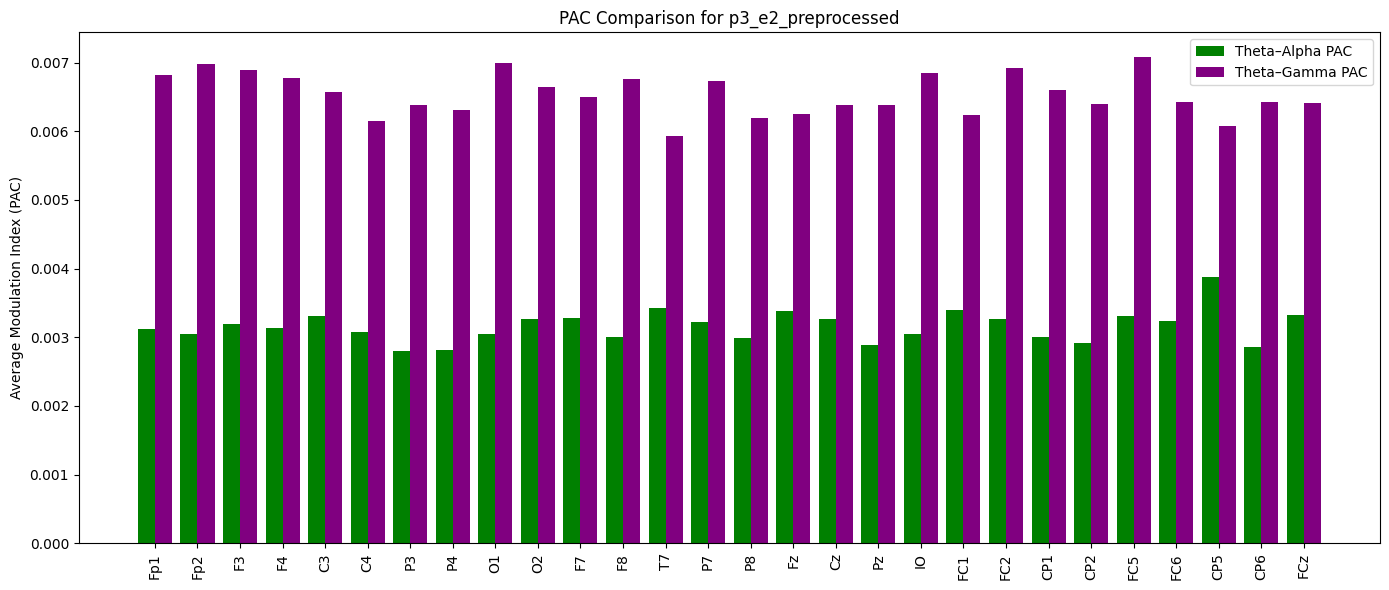

In [ ]:
x = np.arange(len(channel_names))

plt.figure(figsize=(14, 6))
plt.bar(x - 0.2, avg_alpha, width=0.4, label='Theta–Alpha PAC', color='green')
plt.bar(x + 0.2, avg_gamma, width=0.4, label='Theta–Gamma PAC', color='purple')

plt.xticks(x, channel_names, rotation=90)
plt.ylabel("Average Modulation Index (PAC)")
plt.title(f"PAC Comparison for {base_name}")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
!pip install pydrive -q

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def upload_to_drive(local_path, drive_folder_id):
    if os.path.isfile(local_path):
        gfile = drive.CreateFile({'parents': [{'id': drive_folder_id}]})
        gfile.SetContentFile(local_path)
        gfile.Upload()
        print(f'Uploaded file: {os.path.basename(local_path)}')
    elif os.path.isdir(local_path):
        # Create folder in Drive
        folder_name = os.path.basename(local_path)
        folder_metadata = {
            'title': folder_name,
            'mimeType': 'application/vnd.google-apps.folder',
            'parents': [{'id': drive_folder_id}]
        }
        drive_folder = drive.CreateFile(folder_metadata)
        drive_folder.Upload()

        # Upload contents
        for item in os.listdir(local_path):
            item_path = os.path.join(local_path, item)
            if os.path.isfile(item_path):
                gfile = drive.CreateFile({'parents': [{'id': drive_folder['id']}]})
                gfile.SetContentFile(item_path)
                gfile.Upload()
                print(f'Uploaded: {item}')


drive_folder_id = '1f1bgESxBcozHYuEU7AbLZG9Mc5jCGR1B'

# Upload both directories
upload_to_drive('/content/processed_results/theta_alpha', drive_folder_id)
upload_to_drive('/content/processed_results/theta_gamma', drive_folder_id)

print("\nUpload complete! Check your Google Drive folder.")


Uploaded: p3_e2_preprocessed_theta_alpha.npy
Uploaded: p4_e1_preprocessed_theta_alpha.npy
Uploaded: p6_e1_preprocessed_theta_alpha.npy
Uploaded: p5_e2_preprocessed_theta_alpha.npy
Uploaded: p2_e2_preprocessed_theta_alpha.npy
Uploaded: p5_e1_preprocessed_theta_alpha.npy
Uploaded: p1_e2_preprocessed_theta_alpha.npy
Uploaded: p1_e1_preprocessed_theta_alpha.npy
Uploaded: p4_e2_preprocessed_theta_alpha.npy
Uploaded: p6_e2_preprocessed_theta_alpha.npy
Uploaded: p3_e1_preprocessed_theta_alpha.npy
Uploaded: p2_e1_preprocessed_theta_alpha.npy
Uploaded: p4_e2_preprocessed_theta_gamma.npy
Uploaded: p6_e1_preprocessed_theta_gamma.npy
Uploaded: p5_e1_preprocessed_theta_gamma.npy
Uploaded: p2_e1_preprocessed_theta_gamma.npy
Uploaded: p4_e1_preprocessed_theta_gamma.npy
Uploaded: p1_e2_preprocessed_theta_gamma.npy
Uploaded: p3_e1_preprocessed_theta_gamma.npy
Uploaded: p1_e1_preprocessed_theta_gamma.npy
Uploaded: p6_e2_preprocessed_theta_gamma.npy
Uploaded: p5_e2_preprocessed_theta_gamma.npy
Uploaded: 